# Thử nghiệm nhận diện mặt người nổi tiếng Việt Nam

## Phần sử dụng trực tiếp FaceNet + 2 lớp Dense
* Thất bại do:
    * Tập dữ liệu tự làm quá nhỏ, không đủ tốt
    * Thử nghiệm với nhiều hàm optimize (Adam, Adadelta, Adagrad, RMSprop, SGD, ...) + nhiều learning rate khác nhau vẫn không lên nổi
    * Cao nhất được accuracy 20% nhưng chưa kịp lưu thì bị die kernel

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Check for GPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
TEST_PATH = './data/test'
TEST_ALIGNED_PATH = './data/test_aligned'
TRAIN_PATH = './data/train'
TRAIN_ALIGNED_PATH = './data/train_aligned'

BATCH_SIZE = 16
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

In [4]:
random_seed2 = 5

train_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=random_seed2)
val_set = image_dataset_from_directory(TRAIN_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=random_seed2)
test_set = image_dataset_from_directory(TEST_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)


Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [5]:
random_seed = 10

train_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='training', seed=random_seed)
val_aligned_set = image_dataset_from_directory(TRAIN_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE, validation_split=0.2, subset='validation', seed=random_seed)
test_aligned_set = image_dataset_from_directory(TEST_ALIGNED_PATH, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2957 files belonging to 144 classes.
Using 2366 files for training.
Found 2957 files belonging to 144 classes.
Using 591 files for validation.
Found 643 files belonging to 144 classes.


In [6]:
CLASSES = train_set.class_names

NAMES = [line.strip() for line in open('original_labels.txt', 'r', encoding='UTF-8')]

print(len(NAMES))

144


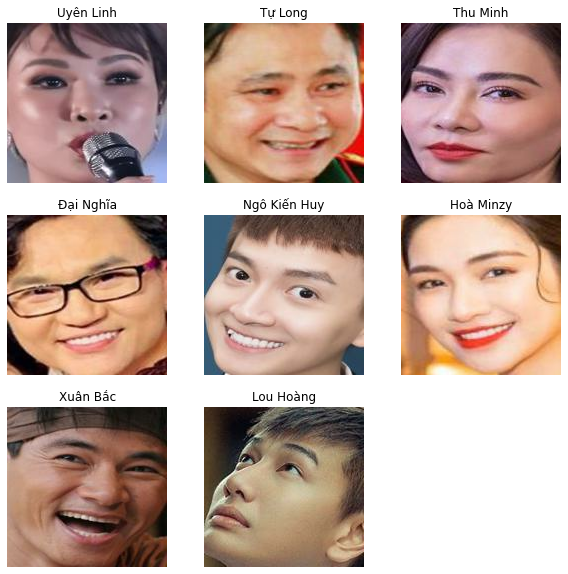

In [7]:
# Show the first 8 images (1 batch) and labels in the training set
plt.figure(figsize = (10, 10))
for images, labels in train_set.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        #print(images[i].numpy().astype('uint8'))
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

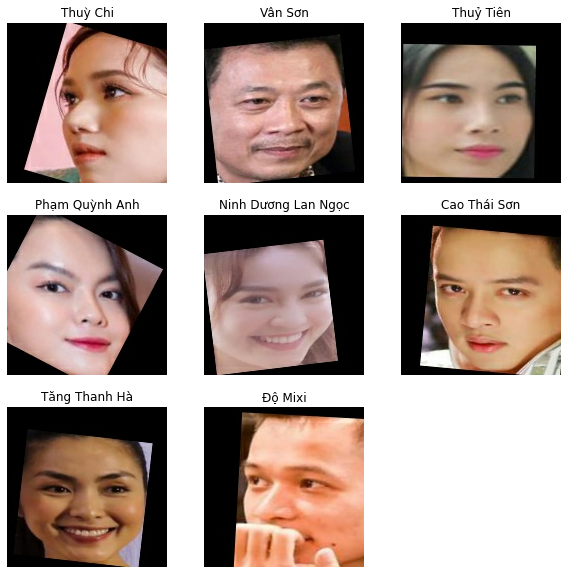

In [8]:
# Try again with aligned train images
plt.figure(figsize = (10, 10))
for images, labels in train_aligned_set.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        #print(images[i].numpy().astype('uint8'))
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(NAMES[int(CLASSES[labels[i]])])
        plt.axis('off')

In [9]:
# To improve image loading performance
AUTOTUNE = tf.data.experimental.AUTOTUNE # for tf 2.3-; for tf 2.4+ remove 'experimental'

train_aligned_set = train_aligned_set.prefetch(buffer_size = AUTOTUNE)
val_set = val_set.prefetch(buffer_size = AUTOTUNE)
test_set = test_set.prefetch(buffer_size = AUTOTUNE)

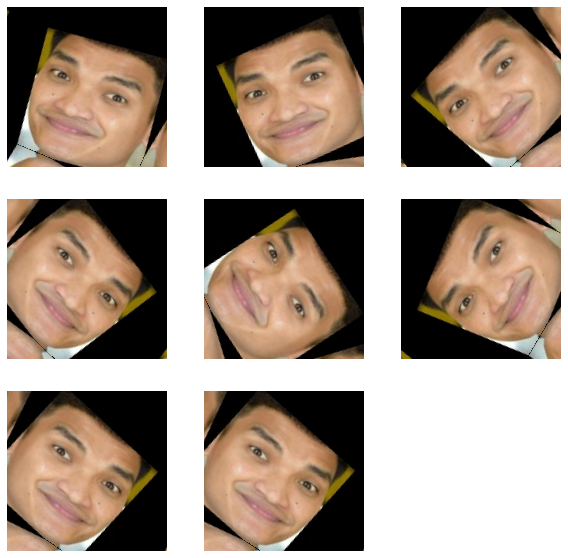

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'), tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
# more augmentation recommended if resource is abundant

# Test with an image to see the augmentations
for images, _ in train_aligned_set.take(1):
    plt.figure(figsize = (10, 10))
    image = images[0]
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [11]:
MODEL_PATH = './models/'

In [12]:
from keras_facenet import FaceNet

fn = FaceNet()

In [13]:
base_model = fn.model 
print(len(base_model.layers))
print(base_model.inputs)
print(base_model.outputs)

448
[<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>]
[<tf.Tensor 'normalize/l2_normalize:0' shape=(None, 512) dtype=float32>]


In [14]:
base_model.summary()

_________________
Block8_1_Concatenate (Concatena (None, None, None, 3 0           Block8_1_Branch_0_Conv2d_1x1_Acti
                                                                 Block8_1_Branch_1_Conv2d_0c_3x1_A
__________________________________________________________________________________________________
Block8_1_Conv2d_1x1 (Conv2D)    (None, None, None, 1 689920      Block8_1_Concatenate[0][0]       
__________________________________________________________________________________________________
lambda_15 (Lambda)              (None, None, None, 1 0           Block8_1_Conv2d_1x1[0][0]        
__________________________________________________________________________________________________
add_15 (Add)                    (None, None, None, 1 0           Mixed_7a[0][0]                   
                                                                 lambda_15[0][0]                  
___________________________________________________________________________________________

In [15]:
image_batch, label_batch = next(iter(train_set))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 512)


In [17]:
base_model.trainable = False
#for layer in base_model.layers[:438]: # Freeze all layers before this point
    #layer.trainable = False

# Add 2 dense layers
dense_layer = tf.keras.layers.Dense(256, activation = 'relu') # if resource allows, try bigger number of neurals
output_layer = tf.keras.layers.Dense(len(CLASSES), activation = 'softmax') # 144 classes, use softmax for multi class

# Compile the model
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = data_augmentation(inputs)
#x = preprocess_input(x) 
x = base_model(x, training = False)

DROPOUT_RATE = 0.2
x = dense_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v1 (Functio (None, 512)               23497424  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 144)               37008     
Total params: 23,665,760
Trainable params: 168,336
Non-trainable params: 23,497,424
____________________________________

In [93]:
model.save_weights(MODEL_PATH + 'pretrained.h5')

In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)

model.load_weights(MODEL_PATH + 'pretrained.h5')

model.compile(optimizer=optim, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [19]:
# initial loss & accuracy
loss0, accuracy0 = model.evaluate(val_set)

37/37 [==============================] - 4s 110ms/step - loss: 4.9714 - accuracy: 0.0085


In [172]:
history = model.fit(train_set, epochs=100, validation_data=val_set) # try more epochs if time allows

Epoch 1/100
148/148 [==============================] - 22s 151ms/step - loss: 4.9781 - accuracy: 0.0059 - val_loss: 4.9755 - val_accuracy: 0.0051
Epoch 2/100
148/148 [==============================] - 19s 131ms/step - loss: 4.9633 - accuracy: 0.0101 - val_loss: 4.9705 - val_accuracy: 0.0102
Epoch 3/100
148/148 [==============================] - 19s 131ms/step - loss: 4.9429 - accuracy: 0.0114 - val_loss: 4.9667 - val_accuracy: 0.0135
Epoch 4/100
148/148 [==============================] - 20s 132ms/step - loss: 4.9113 - accuracy: 0.0156 - val_loss: 4.9733 - val_accuracy: 0.0085
Epoch 5/100
148/148 [==============================] - 20s 132ms/step - loss: 4.8925 - accuracy: 0.0182 - val_loss: 4.9485 - val_accuracy: 0.0118
Epoch 6/100
148/148 [==============================] - 20s 133ms/step - loss: 4.8767 - accuracy: 0.0194 - val_loss: 4.9314 - val_accuracy: 0.0118
Epoch 7/100
148/148 [==============================] - 19s 130ms/step - loss: 4.8617 - accuracy: 0.0211 - val_loss: 4.9244 -

In [173]:
model.save_weights(MODEL_PATH + 'training_weights_ckp_1.h5')

In [174]:
hists = []
hists.append(history)

In [21]:
model.load_weights(MODEL_PATH + 'training_weights_ckp_1.h5')
optim.learning_rate.assign(0.005)
history = model.fit(train_set, epochs=100, validation_data=val_set)

Epoch 1/100
148/148 [==============================] - 18s 125ms/step - loss: 4.5964 - accuracy: 0.0351 - val_loss: 4.7255 - val_accuracy: 0.0355
Epoch 2/100
148/148 [==============================] - 18s 124ms/step - loss: 4.5766 - accuracy: 0.0309 - val_loss: 4.6644 - val_accuracy: 0.0321
Epoch 3/100
148/148 [==============================] - 18s 123ms/step - loss: 4.5515 - accuracy: 0.0389 - val_loss: 4.7294 - val_accuracy: 0.0305
Epoch 4/100
148/148 [==============================] - 18s 124ms/step - loss: 4.5365 - accuracy: 0.0456 - val_loss: 4.6786 - val_accuracy: 0.0372
Epoch 5/100
148/148 [==============================] - 18s 123ms/step - loss: 4.5194 - accuracy: 0.0486 - val_loss: 4.7206 - val_accuracy: 0.0338
Epoch 6/100
148/148 [==============================] - 18s 123ms/step - loss: 4.5407 - accuracy: 0.0402 - val_loss: 4.6632 - val_accuracy: 0.0237
Epoch 7/100
148/148 [==============================] - 18s 123ms/step - loss: 4.5348 - accuracy: 0.0402 - val_loss: 4.7324 -

In [23]:
model.evaluate(test_set)

41/41 [==============================] - 5s 129ms/step - loss: 4.8260 - accuracy: 0.0778


[4.826004981994629, 0.0777604952454567]

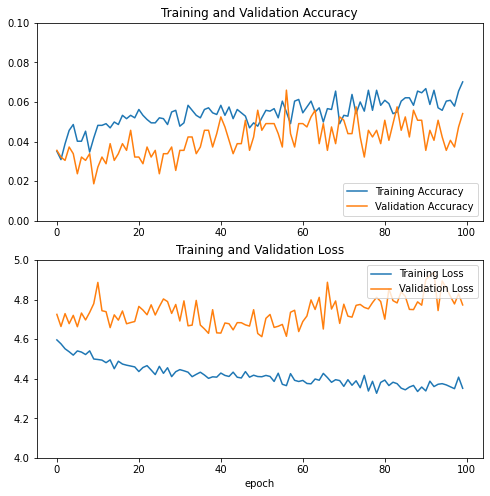

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.0, 0.1])
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([4.0, 5.0])
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.xlabel('epoch')
plt.show()

## Phần thử nghiệm với embedding vectors
* 512 chiều, không khả thi để train (do máy hơi cùi), 1 epoch chạy rất lâu

In [114]:
emb_gen = FaceNet()

In [144]:
def prepare_emb(dataset):
    return dataset.map(lambda img, lbl: (emb_gen.model(img), lbl))

In [145]:
emb_train_set = prepare_emb(train_set)
emb_test_set = prepare_emb(test_set)
emb_val_set = prepare_emb(val_set)

In [147]:
emb_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, input_dim=512, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax'),
    ]
)
emb_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 144)               73872     
Total params: 336,528
Trainable params: 336,528
Non-trainable params: 0
_________________________________________________________________


In [158]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

emb_model.compile(optimizer=optim, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [159]:
emb_hist = emb_model.fit(emb_train_set, epochs=50, validation_data=emb_val_set)

Epoch 1/50
148/148 [==============================] - 94s 634ms/step - loss: 4.9931 - accuracy: 0.0025 - val_loss: 4.9717 - val_accuracy: 0.0017
Epoch 2/50
148/148 [==============================] - 93s 630ms/step - loss: 4.9083 - accuracy: 0.0106 - val_loss: 4.9400 - val_accuracy: 0.0102
Epoch 3/50
148/148 [==============================] - 91s 612ms/step - loss: 4.8436 - accuracy: 0.0148 - val_loss: 4.9069 - val_accuracy: 0.0118
Epoch 4/50
148/148 [==============================] - 95s 639ms/step - loss: 4.8100 - accuracy: 0.0118 - val_loss: 4.9052 - val_accuracy: 0.0118
Epoch 5/50
148/148 [==============================] - 95s 642ms/step - loss: 4.7902 - accuracy: 0.0135 - val_loss: 4.8944 - val_accuracy: 0.0068
Epoch 6/50
148/148 [==============================] - 93s 631ms/step - loss: 4.7797 - accuracy: 0.0123 - val_loss: 4.9372 - val_accuracy: 0.0085
Epoch 7/50
148/148 [==============================] - 93s 632ms/step - loss: 4.7619 - accuracy: 0.0144 - val_loss: 4.8728 - val_ac

KeyboardInterrupt: 